# Dose-Response Curves and Logistic Regression

This notebook uses the processed data outputs from the hexosaminidase and LDH assay analysis notebooks to generate dose-response curves. It is useful for experiments that test many doses of a particular activator, and for identifying non-toxic treatment concentrations that can induce degranulation.

### Inputs
The input data for this notebook are processed datafiles (`labeled_datafile_hex` and `labeled_datafile_ldh`) that are outputs of the hexosaminidase and LDH assay analysis notebooks (`hex_assay_analysis_main.ipynb` and `ldh_assay_analysis_main.ipynb`, respectively). The hexosaminidase assay file name has the suffix `_labeled` after the original raw data file name, and the LDH assay file has the suffix `_ldh_concs_filtered`.

Other parameters defined by the user include the names of control samples `positive_control`, `negative_control`, and `ldh_assay_control`, and the hexosaminidase assay standard values `standard_vals_hex`, which are not plotted. The parameter `experiment_name` is used to label plots.

### Outputs
Each input processed data file (hexosaminidase and LDH) produces a plot of the dose-response points and a plot of these points with an associated sigmoid fit curve. These are plotted with log<sub>10</sub>(concentration) values on the x-axis and are exported as png files.

To facilitate comparison between assays, the y-values of each dataset and their sigmoid fits are normalized to a relative response between 0 and 1. These transformed results are also plotted and exported as a png file.

The notebook stores outputs for the hexosaminidase and LDH assays in the same output subdirectory as the inputs. The superimposed curve is stored in the hexosamindase output directory.

In [1]:
import os
import re

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# Parameterization.

labeled_datafile_hex = "../output_files/20250205_2_hex_assay/20250205_2_hex_assay_labeled.csv"
labeled_datafile_ldh = (
    "../output_files/20250205_ldh_assay/20250205_ldh_assay_ldh_concs_filtered.csv"
)

positive_control = "Lysed"
negative_control = "PBS"
ldh_assay_control = "LDH Positive Control"

# enter the standard labels as a list of strings.
standard_vals_hex = [
    "500",
    "250",
    "125",
    "0",
]

In [3]:
if os.path.exists(labeled_datafile_hex):
    labeled_data_hex = pd.read_csv(labeled_datafile_hex)
    print(f"File '{labeled_datafile_hex}' loaded successfully.")
else:
    print(f"Error: File '{labeled_datafile_hex}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

labeled_data_hex

File '../output_files/20250205_2_hex_assay/20250205_2_hex_assay_labeled.csv' loaded successfully.


,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,Lysed,PBS,500,250,125,0
0,131767127.0,99325623.0,34204015.0,24050219.0,27696721.0,23224649.0,32967509.0,33565967.0,16797609.0,33195803.0,17020257.0,9223458.0,2540751.0
1,125584239.0,101056727.0,38084283.0,22608975.0,26204827.0,25589889.0,26892391.0,NaN,16029528.0,31097249.0,15862801.0,8661546.0,2628135.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32092959.0,15924483.0,8796540.0,2633184.0


In [4]:
labeled_data_hex = labeled_data_hex.drop(columns=standard_vals_hex)
labeled_data_hex

,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,Lysed,PBS
0,131767127.0,99325623.0,34204015.0,24050219.0,27696721.0,23224649.0,32967509.0,33565967.0,16797609.0
1,125584239.0,101056727.0,38084283.0,22608975.0,26204827.0,25589889.0,26892391.0,NaN,16029528.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Sample concentrations must be represented as floats to plot a dose-response curve.


def parse_sample_concentrations(sample):
    """
    Parses sample concentrations from strings with µg/mL and ng/mL unit labels into floats in µg/mL.
    Returns None for samples without a unit label.

    Args:
        sample: A sample name, as a string.

    Returns:
        float: The sample concentration in µg/mL.
    """
    match = re.search(r"([\d\.]+)\s*(µg|ng)/mL", sample)
    if match:
        value, unit = float(match.group(1)), match.group(2)
        return value if unit == "µg" else value / 1000
    return None


float_concentration_data_hex = {}

for col in labeled_data_hex.columns:
    concentration = parse_sample_concentrations(col)
    if concentration is not None:
        float_concentration_data_hex[concentration] = labeled_data_hex[col]

float_concentration_df_hex = pd.DataFrame(float_concentration_data_hex)
float_concentration_df_hex

,66.7000,22.2000,7.4100,2.4700,0.8230,0.2740,0.0305
0,131767127.0,99325623.0,34204015.0,24050219.0,27696721.0,23224649.0,32967509.0
1,125584239.0,101056727.0,38084283.0,22608975.0,26204827.0,25589889.0,26892391.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


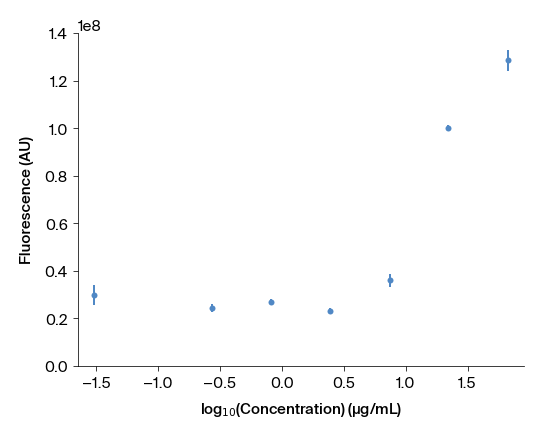

In [6]:
log_concentrations_hex = np.log10(float_concentration_df_hex.columns.astype(float))

means = float_concentration_df_hex.mean()
std_devs = float_concentration_df_hex.std()

apc.mpl.setup()
plt.figure(figsize=(8, 6))
plt.errorbar(log_concentrations_hex, means, yerr=std_devs, fmt="o", capsize=5, label="Data")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("Fluorescence (AU)")

plt.ylim(0, 1.4e8)

plt.savefig(labeled_datafile_hex[:-4] + "_doseresponse.png", transparent=False)
plt.show()

In [7]:
# Logistic fit works best for dose response data with log(concentration).


def sigmoid(x, bottom, top, log_EC50, slope):
    return bottom + (top - bottom) / (1 + np.exp(-slope * (x - log_EC50)))


x_data_hex = log_concentrations_hex
y_data_hex = float_concentration_df_hex.mean().values

p0 = [min(y_data_hex), max(y_data_hex), np.median(x_data_hex), 1]

try:
    params_hex, _ = curve_fit(sigmoid, x_data_hex, y_data_hex, p0=p0)
    EC50 = 10 ** params_hex[2]

    y_pred_hex = sigmoid(x_data_hex, *params_hex)

    ss_res = np.sum((y_data_hex - y_pred_hex) ** 2)
    ss_tot = np.sum((y_data_hex - np.mean(y_data_hex)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print("Fitted Parameters:")
    print(f"  Min: {params_hex[0]:.2e}")
    print(f"  Max: {params_hex[1]:.2e}")
    print(f"  EC50: {EC50:.3f} µg/mL")
    print(f"  Slope: {params_hex[3]:.3f}")
    print("Goodness of Fit:")
    print(f"  R²: {r_squared:.4f}")

except Exception as e:
    print("⚠️ Logistic regression failed for hex data.")
    print(f"Error: {e}")
    params_hex = None

Fitted Parameters:
  Min: 2.61e+07
  Max: 1.30e+08
  EC50: 16.261 µg/mL
  Slope: 6.668
Goodness of Fit:
  R²: 0.9974


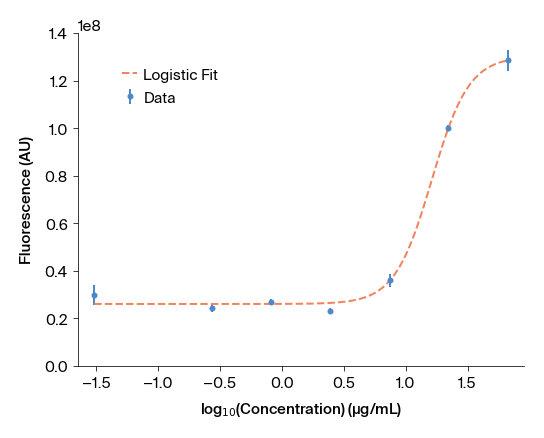

In [8]:
if params_hex is not None:
    x_fit_hex = np.linspace(min(x_data_hex), max(x_data_hex), 100)
    y_fit_hex = sigmoid(x_fit_hex, *params_hex)

    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_data_hex,
        y_data_hex,
        yerr=float_concentration_df_hex.std(),
        fmt="o",
        capsize=5,
        label="Data",
    )
    plt.plot(x_fit_hex, y_fit_hex, label="Logistic Fit", linestyle="--")

    plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
    plt.ylabel("Fluorescence (AU)")
    plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.ylim(0, 1.4e8)

    plt.savefig(labeled_datafile_hex[:-4] + "_doseresponse_curvefit.png", transparent=False)
    plt.show()

else:
    print("No logistic regression curve to plot.")

In [9]:
if os.path.exists(labeled_datafile_ldh):
    labeled_data_ldh = pd.read_csv(labeled_datafile_ldh)
    print(f"File '{labeled_datafile_ldh}' loaded successfully.")
else:
    print(f"Error: File '{labeled_datafile_ldh}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

labeled_data_ldh

File '../output_files/20250205_ldh_assay/20250205_ldh_assay_ldh_concs_filtered.csv' loaded successfully.


,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,66.7 µg/mL,0.731,1.944,195.278150,603.384962,5,5101.335157
1,66.7 µg/mL,0.741,1.962,198.075627,610.741830,5,5158.327541
2,66.7 µg/mL,0.755,1.909,201.998204,589.239770,5,4840.519571
3,22.2 µg/mL,0.322,0.892,83.813480,243.043033,5,1990.369420
4,22.2 µg/mL,0.348,0.939,90.735839,257.011227,5,2078.442353
5,22.2 µg/mL,0.310,0.819,80.625655,221.637093,5,1762.642978
6,7.41 µg/mL,0.062,0.173,15.716848,45.348559,5,370.396384
7,7.41 µg/mL,0.064,0.174,16.233097,45.605577,5,367.155999
8,7.41 µg/mL,0.064,0.169,16.233097,44.320922,5,351.097808
9,2.47 µg/mL,0.366,0.866,95.540672,235.379294,1,349.596556


In [10]:
# Input data will be transformed to facilitate fits and plotting.

labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != positive_control]
labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != negative_control]
labeled_data_ldh = labeled_data_ldh[labeled_data_ldh["Sample"] != ldh_assay_control]
labeled_data_ldh = labeled_data_ldh.drop(labeled_data_ldh.columns[1:4], axis=1)
data_dict = labeled_data_ldh.groupby("Sample")["LDH"].apply(list).to_dict()
ldh_data_transposed = pd.DataFrame(data_dict)
ldh_data_transposed

,10.2 ng/mL,2.47 µg/mL,22.2 µg/mL,274 ng/mL,30.5 ng/mL,66.7 µg/mL,7.41 µg/mL,823 ng/mL,91.5 ng/mL
0,312.780197,349.596556,1990.369420,342.130188,338.299057,5101.335157,370.396384,396.069060,328.875289
1,316.028618,344.496458,2078.442353,328.657690,360.761470,5158.327541,367.155999,360.716179,319.228329
2,312.930143,344.969201,1762.642978,348.464066,360.808458,4840.519571,351.097808,376.773298,351.183342


In [11]:
float_concentration_data_ldh = {}

for col in ldh_data_transposed.columns:
    concentration = parse_sample_concentrations(col)
    if concentration is not None:
        float_concentration_data_ldh[concentration] = ldh_data_transposed[col]

float_concentration_df_ldh = pd.DataFrame(float_concentration_data_ldh)
float_concentration_df_ldh

,0.0102,2.4700,22.2000,0.2740,0.0305,66.7000,7.4100,0.8230,0.0915
0,312.780197,349.596556,1990.369420,342.130188,338.299057,5101.335157,370.396384,396.069060,328.875289
1,316.028618,344.496458,2078.442353,328.657690,360.761470,5158.327541,367.155999,360.716179,319.228329
2,312.930143,344.969201,1762.642978,348.464066,360.808458,4840.519571,351.097808,376.773298,351.183342


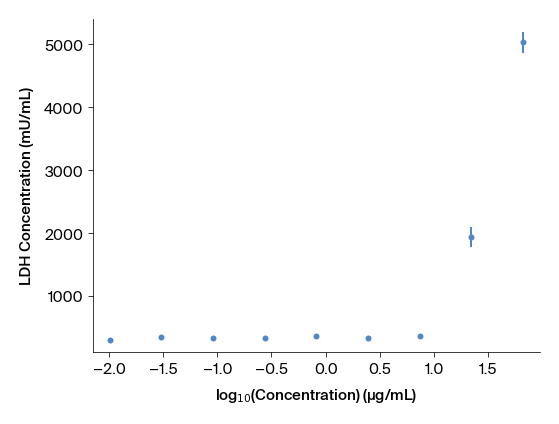

In [12]:
log_concentrations_ldh = np.log10(float_concentration_df_ldh.columns.astype(float))

means = float_concentration_df_ldh.mean()
std_devs = float_concentration_df_ldh.std()

plt.figure(figsize=(8, 6))
plt.errorbar(log_concentrations_ldh, means, yerr=std_devs, fmt="o", capsize=5, label="Data")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("LDH Concentration (mU/mL)")

plt.savefig(labeled_datafile_ldh[:-4] + "_doseresponse.png", transparent=False)
plt.show()

In [13]:
x_data_ldh = log_concentrations_ldh
y_data_ldh = float_concentration_df_ldh.mean().values

p0 = [min(y_data_ldh), max(y_data_ldh), np.median(x_data_ldh), 1]

try:
    params_ldh, _ = curve_fit(sigmoid, x_data_ldh, y_data_ldh, p0=p0)
    LC50 = 10 ** params_ldh[2]

    y_pred_ldh = sigmoid(x_data_ldh, *params_ldh)

    ss_res = np.sum((y_data_ldh - y_pred_ldh) ** 2)
    ss_tot = np.sum((y_data_ldh - np.mean(y_data_ldh)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print("Fitted Parameters:")
    print(f"  Min: {params_ldh[0]:.2e}")
    print(f"  Max: {params_ldh[1]:.2e}")
    print(f"  LC50: {LC50:.3f} µg/mL")
    print(f"  Slope: {params_ldh[3]:.3f}")
    print("Goodness of Fit:")
    print(f"  R²: {r_squared:.4f}")

except Exception as e:
    print("⚠️ Logistic regression failed for LDH data.")
    print(f"Error: {e}")
    params_ldh = None

Fitted Parameters:
  Min: 3.44e+02
  Max: 5.11e+03
  LC50: 25.905 µg/mL
  Slope: 10.163
Goodness of Fit:
  R²: 0.9999


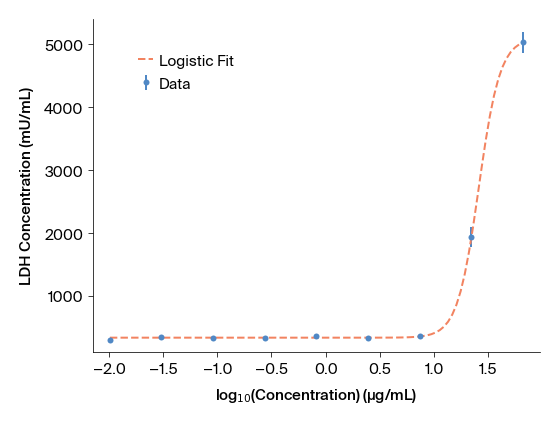

In [14]:
if params_ldh is not None:
    x_fit_ldh = np.linspace(min(x_data_ldh), max(x_data_ldh), 100)
    y_fit_ldh = sigmoid(x_fit_ldh, *params_ldh)

    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_data_ldh,
        y_data_ldh,
        yerr=float_concentration_df_ldh.std(),
        fmt="o",
        capsize=5,
        label="Data",
    )
    plt.plot(x_fit_ldh, y_fit_ldh, label="Logistic Fit", linestyle="--")

    plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
    plt.ylabel("LDH Concentration (mU/mL)")
    plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.savefig(labeled_datafile_ldh[:-4] + "_doseresponse_curvefit.png", transparent=False)
    plt.show()

else:
    print("No logistic regression curve to plot.")

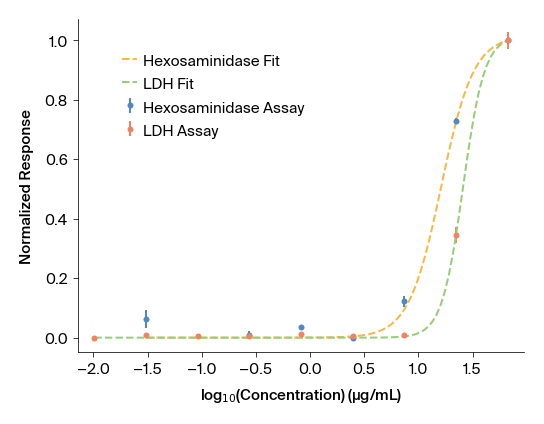

In [15]:
# Response values need to be normalized in order to plot them on the same graph.
# This will enable us to compare the response of each assay at a particular concentration.


def normalize_dataframe(df):
    """
    Normalizes the range of output values in a dataframe (i.e., a dose-response
    dataset) to relative values between 0 and 1 to facilitate comparison.

    Args:
        df: A pandas DataFrame to be normalized.

    Returns
        pd.DataFrame: The normalized DataFrame.
    """
    y_values = df.mean().values
    min_val = np.min(y_values)
    max_val = np.max(y_values)
    return (df - min_val) / (max_val - min_val)


def normalize_fit(y_values):
    """
    Normalizes the range of a sigmoid fit curve to relative values
    between 0 and 1 to facilitate comparisons.

    Args:
        y_values:
            The y-values of a sigmoid curve fit as a list of floats.

    Returns:
        list[float]: The normalized sigmoid curve y-values.
    """
    min_val = np.min(y_values)
    max_val = np.max(y_values)
    return (y_values - min_val) / (max_val - min_val)


hex_normalized = normalize_dataframe(float_concentration_df_hex)
ldh_normalized = normalize_dataframe(float_concentration_df_ldh)

if params_hex is not None:
    hex_fit_normalized = normalize_fit(sigmoid(x_fit_hex, *params_hex))

if params_ldh is not None:
    ldh_fit_normalized = normalize_fit(sigmoid(x_fit_ldh, *params_ldh))

hex_normalized_mean = hex_normalized.mean().values
ldh_normalized_mean = ldh_normalized.mean().values

plt.figure(figsize=(8, 6))
plt.errorbar(
    x_data_hex,
    hex_normalized_mean,
    yerr=np.std(hex_normalized, axis=0),
    fmt="o",
    capsize=5,
    label="Hexosaminidase Assay",
)
plt.errorbar(
    x_data_ldh,
    ldh_normalized_mean,
    yerr=np.std(ldh_normalized, axis=0),
    fmt="o",
    capsize=5,
    label="LDH Assay",
)

if params_hex is not None:
    plt.plot(x_fit_hex, hex_fit_normalized, linestyle="--", label="Hexosaminidase Fit")

if params_ldh is not None:
    plt.plot(x_fit_ldh, ldh_fit_normalized, linestyle="--", label="LDH Fit")

plt.xlabel(r"log$_{10}$(Concentration) (µg/mL)")
plt.ylabel("Normalized Response")
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.savefig(
    labeled_datafile_hex[:-4] + "_doseresponse_curvefit_superimposed.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [16]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.5', 'json': '2.0.9', 'jupyter_client._version': '8.6.3', 'platform': '1.0.8', 'zmq.sugar.version': '26.2.1', 'zmq.sugar': '26.2.1', 'zmq': '26.2.1', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.17.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.3.6', 'platformdirs': '4.3.6', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.3', 'ipykernel': '6.29.5', 'IPython.core.release': '8.32.0', 'executing.version': '2.1.0', 'executing': '2.1.0', 'pure_eval.version': '0.2.3', 'pure_eval': '0.2.3', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.19.1', 'pickleshare': '0.7.5', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.50', 'parso': '0